# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.dummy import DummyClassifier

In [2]:
RANDOM_NUM = 171

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


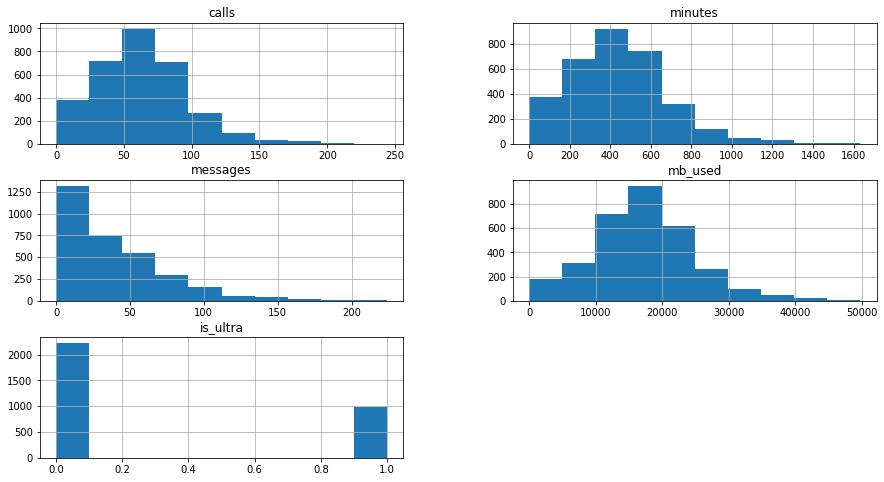

In [3]:
df_full = pd.read_csv('/datasets/users_behavior.csv')
df_full.info()
df_full.hist(figsize=(15,8));
df_full.describe()

- `сalls` — количество звонков,
-    `minutes` — суммарная длительность звонков в минутах,
-    `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Всего 3214 строки. Пропущенных значений нет. Предобработка данных выполнена по условию. 


Можно обратить внимание, что основная часть `mb_user` содержит достаточно большие значения и значительно отличается от остальных. Переведем значения этого столбца в гигабайты.  

In [4]:
df_full['mb_used'] = df_full['mb_used'] / 1024
df_full.rename(columns={'mb_used': 'gb_used'}, inplace=True)

In [5]:
df_full['gb_used'].describe()

count    3214.000000
mean       16.804369
std         7.393524
min         0.000000
25%        12.199124
50%        16.546128
75%        20.922559
max        48.579814
Name: gb_used, dtype: float64

Целью исследования является определить тариф, в данных это определяется параметром `is_ultra`. Рассмотрим его подробнее

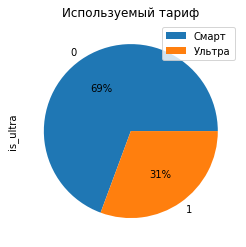

In [6]:
df_full['is_ultra'].value_counts().plot.pie(title='Используемый тариф', autopct='%1.0f%%')
plt.legend(['Смарт','Ультра']);

В данных есть информации всего по 2 тарифам - Смарт (`is_ultra` = 0) и Ультра (`is_ultra` = 1). Тарифом Ультра пользовалось 31% пользователей, а тарифом Смарт - 69%. 

Попробуем оценить, какие значения параметров "характерны" для каждого из тарифов. 

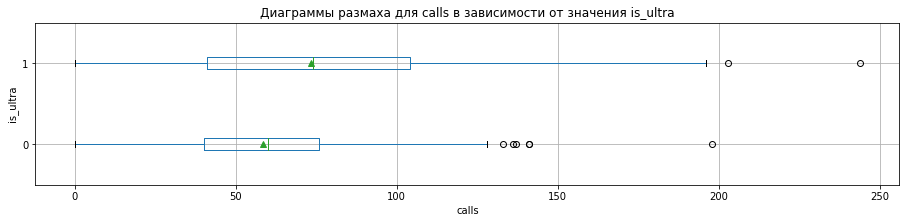

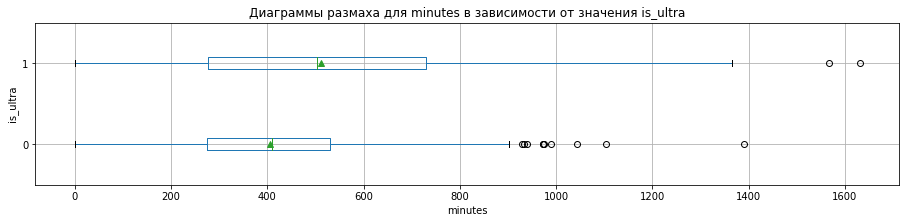

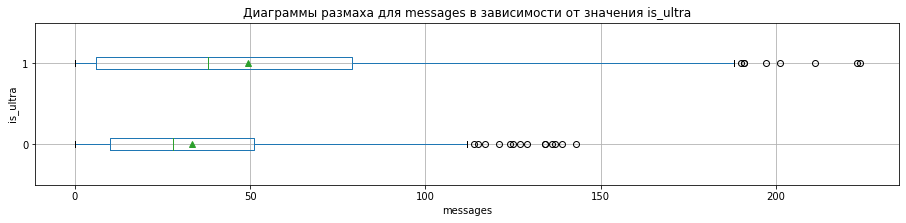

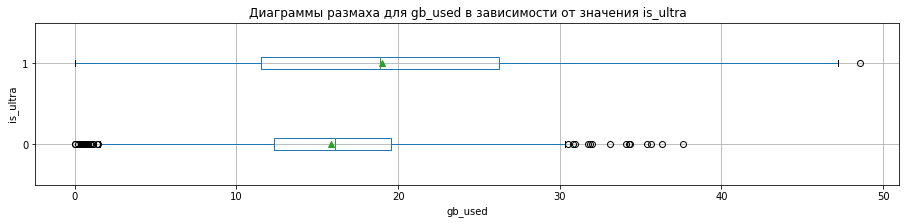

In [7]:
for col_name in df_full.columns[:-1]:
    df_full.boxplot(column=col_name, by='is_ultra', vert=False, figsize=(15,3), showmeans=True)
    plt.xlabel(col_name)
    plt.ylabel('is_ultra')
    plt.title(f'Диаграммы размаха для {col_name} в зависимости от значения is_ultra')
    plt.suptitle('');

По диаграммам размаха можно оценить, что пользователи, которые больше пользуются связью(все параметры) выбирают тариф "Ультра", т.е. можно предположить, что выбор тарифа не является случайным и зависит от того, как много пользователь тратит минут/сообщений/мегабайт. Это значит, что имеет смысл попробовать построить модель.

## Разбиение на выборки

Целью исследования является выбор подходящего тарифа, значит, целевой признак - `is_ultra` - категориальный, который  имеет только два значения. <br>


Сначала разобьем данные на целевой признак и остальные признаки.

In [8]:
full_features = df_full.drop('is_ultra', axis=1) # X
full_target = df_full['is_ultra'] # y

На качество модели может негативно влиять мультиколлинеарность признаков. Проверим

In [9]:
full_features.corr()

,calls,minutes,messages,gb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
gb_used,0.286442,0.280967,0.195721,1.000000


Параметры `calls` и `minutes` имеют очень высокую положительную корреляцию. Исключим призак `calls` (т.к. в тарифах обычно платят за количество минут, логичнее оставить этот параметр именно в минутах).

In [10]:
full_features = full_features.drop('calls', axis=1)

Будем разбивать наши данные на три выборки:
- обучающая 60%
- валидационная 20%
- тестовая 20%

In [11]:
train = namedtuple('features', 'target')
validate = namedtuple('features', 'target')
test = namedtuple('features', 'target')

In [12]:
train.features, test.features, train.target, test.target = train_test_split(full_features, 
                                                                            full_target, 
                                                                            test_size=0.2,
                                                                            random_state=RANDOM_NUM,
                                                                            stratify=full_target)

train.features, validate.features, train.target, validate.target = train_test_split(train.features, 
                                                                                    train.target,
                                                                                    test_size=0.25,
                                                                                    random_state=RANDOM_NUM,
                                                                                    stratify=train.target)

Проверим размер получившихся выборок:

In [13]:
print(f"Размер обучающей выборки {len(train.features)}, процент от общей {len(train.features)/len(full_features):.0%}")
print(f"Размер валидационной выборки {len(validate.features)}, процент от общей {len(validate.features)/len(full_features):.0%}")
print(f"Размер тестовой выборки {len(test.features)}, процент от общей {len(test.features)/len(full_features):.0%}")

Размер обучающей выборки 1928, процент от общей 60%
Размер валидационной выборки 643, процент от общей 20%
Размер тестовой выборки 643, процент от общей 20%


Размер полученных выборок соответствует необходимому, можно переходить к постоению и исследованию моделей.

## Исследование моделей

**Используемая функция:**

In [14]:
def create_model(model_name: str, 
                 data: namedtuple = train, 
                 pred: namedtuple = validate, 
                 random_state_ : int = RANDOM_NUM,
                 show_tree: bool = False,
                 **kwargs) -> list:
    
    model = eval(model_name)(random_state=random_state_, **kwargs)
    model.fit(data.features, data.target) 
    accur = model.score(pred.features, pred.target)
    if show_tree and depth < 5:
        plt.figure(figsize=(20,depth*2))
        plot_tree(model, 
                  fontsize=8, 
                  filled=True, 
                  feature_names=data.features.columns,
                  class_names=['Смарт', 'Ультра']
                 )
        plt.title(f'Дерево решений при глубине {depth}')
        plt.show()
    return [accur, model_name, kwargs]

Т.к. целевой параметр может принимать только два значения, стоит задача бинарной классификации. <br>
Будем использовать три алгоритма:
- DecisionTreeClassifier (дерево решений) - будем использовать с различной глубиной дерева (max_depth)
- RandomForestClassifier (случайный лес) - будем использовать с различной глубиной дерева (max_depth) и количеством деревьев(n_estimators)
- LogisticRegression (логистическая регрессия) - будем использовать с стандартным решателем (solver) 'lbfgs' 


Для оценки модели будем использовать валидационный набор данных и метод `score()` для оценки модели. Полученную информацию внесем в список

In [15]:
models = []

**Дерево решений**
- глубина дерева от 1 до 9

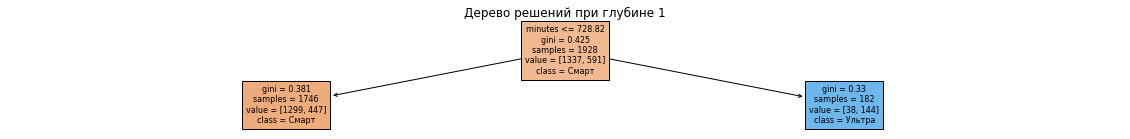

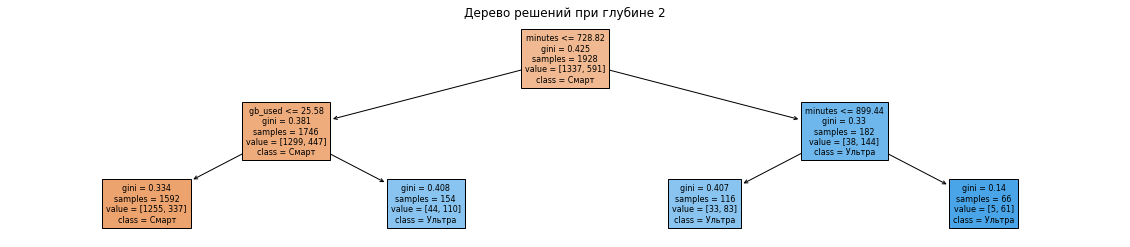

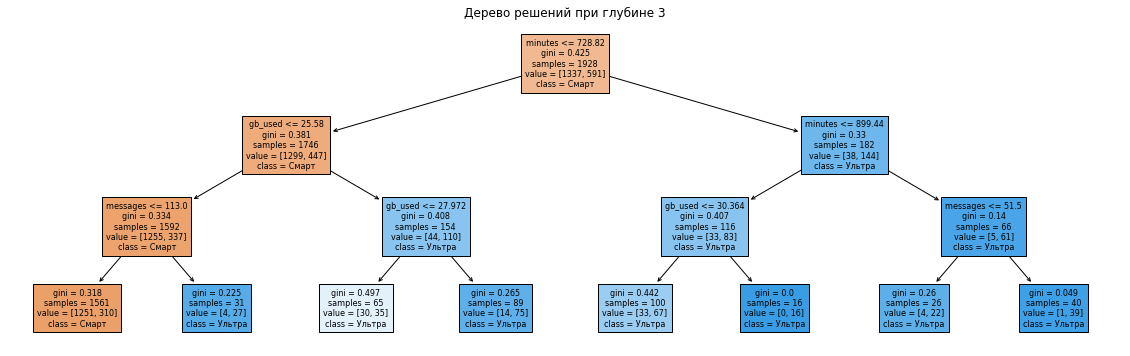

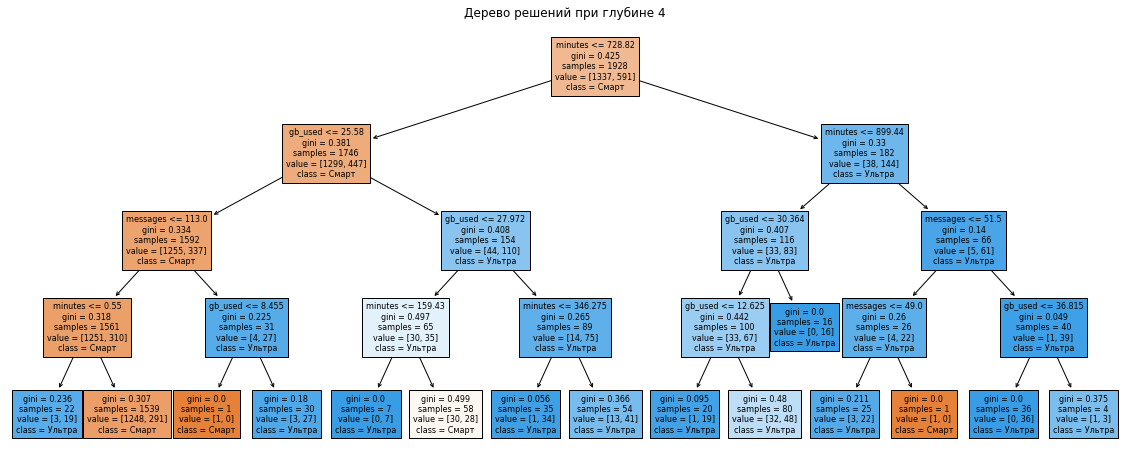

In [16]:
for depth in range(1,10):
    models.append(create_model('DecisionTreeClassifier', show_tree=True, max_depth=depth))

**Случайный лес**
- глубина дерева от 1 до 8
- количество деревьев от 2 до 40, 100, 150, 200

In [17]:
%%time
for depth in range(1,9):
    for estim in [*range(2,41), 100, 150, 200]:
        models.append(create_model('RandomForestClassifier', n_estimators=estim, max_depth=depth))

CPU times: user 19.6 s, sys: 137 ms, total: 19.8 s
Wall time: 19.9 s


**Логистическая регрессия**
- максимальное количество итераций 1000

In [19]:
models.append(create_model('LogisticRegression', max_iter=1000))

Посмотрим, какие модели показали лучшие результаты:

In [20]:
models = pd.DataFrame(models, columns=['accuracy','model_type','arrgs'])

In [21]:
models.sort_values(by='accuracy').groupby('model_type').tail()

,accuracy,model_type,arrgs
345,0.772939,LogisticRegression,{'max_iter': 1000}
5,0.786936,DecisionTreeClassifier,{'max_depth': 6}
7,0.790047,DecisionTreeClassifier,{'max_depth': 8}
2,0.797823,DecisionTreeClassifier,{'max_depth': 3}
4,0.799378,DecisionTreeClassifier,{'max_depth': 5}
3,0.802488,DecisionTreeClassifier,{'max_depth': 4}
185,0.813375,RandomForestClassifier,"{'n_estimators': 10, 'max_depth': 5}"
266,0.813375,RandomForestClassifier,"{'n_estimators': 7, 'max_depth': 7}"
182,0.814930,RandomForestClassifier,"{'n_estimators': 7, 'max_depth': 5}"
262,0.816485,RandomForestClassifier,"{'n_estimators': 3, 'max_depth': 7}"


Среди всех моделей самый плохой результат у **логистической регрессии** - 0.773. <br>
Второй результат у **дерева решений** точность при глубине 4  - 0.802 <br>
Самый лучший результат показала модель **случайный лес** - одинаковый результат 0.816 при глубине 7 и количестве деревьев 6 и глубине 7 и количестве деревьев 3.

## Проверка модели на тестовой выборке

Для проверки на тестовых данных будем использовть модель, которая показала лучшие результаты на валидационных данных (**случайный лес** при глубине 7 и количестве деревьев 6)


Построим модель

In [22]:
final_model = RandomForestClassifier(random_state=RANDOM_NUM, n_estimators=6, max_depth=7)
final_model.fit(train.features, train.target) 
pred = final_model.predict(test.features) 
pred[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1])

Затем проверим ее на тестовых данных

In [23]:
final_model.score(test.features, test.target)

0.8149300155520995

Точность составила **0.815**. Можно сказать, что модель показала хороший результат на тестовых данных.

Попробуем переобучить нашу модель на большей выборке.

In [24]:
train_big = namedtuple('features', 'target')
train_big.features = pd.concat([train.features, validate.features])
train_big.target = pd.concat([train.target, validate.target])

create_model('RandomForestClassifier', data=train_big, pred=test, n_estimators=6, max_depth=7)

[0.8009331259720062,
 'RandomForestClassifier',
 {'n_estimators': 6, 'max_depth': 7}]

Модель так же показала хороший результат (точность **0.801**)

## Проверка модели на адекватность

Для проверки модели на адекватность необходимо, чтоб она она показывала лучший результат, чем случайная генерация.

Используем три разных стратегии для генерации ответов:
- один вариант, который встречается чаще всего
- равномерное распределение
- стратифицированная

In [25]:
for strat in ['most_frequent', 'uniform', 'stratified']:
    dummy = DummyClassifier(strategy=strat, random_state=RANDOM_NUM).fit(train.features, train.target)
    dummy_pred = dummy.predict(test.features)
    print(f"Для стратегии {strat} точность {accuracy_score(test.target, dummy_pred)}")

Для стратегии most_frequent точность 0.6936236391912908
Для стратегии uniform точность 0.5132192846034215
Для стратегии stratified точность 0.5629860031104199


Самая большая точность у стратегии `most_frequent` - сгенерированы ответы, состоящие только из нулей. Это достаточно большая точность, но несколько абсурдная, т.к., по сути, не содержит реальных рекомендации, а просто предлагает наиболее популярное. Точность стратифицированных ответов около **56%**.

Можно сделать вывод, что выбранная модель значительно лучше прогнозирует (для тестовой выборки точность **81.5%**)

## Общий вывод

Было проведено исследование и построение модели с целью определения, какой тариф подойдет пользователю в зависимости от количества используемых минут, сообщений и израсходованного интернет-трафика. <br>
Было рассмотрено три алгоритма (дерево решений, случайный лес и логистическая регрессия) для построения моделей с разными гиперпараметрами. <br>
По итогу была выбрана модель, построенная по алгоритму `RandomForestClassifier (случайный лес)` с гиперпараметрами глубина дерева `7` и число деревьев `6`. <br>
На валидационной выборке модель показала результат в **81.6%** точности, на тестовой выборке **81.5%** точности. Оба результата значительно лучше, чем точность при случайном подборе (**69%**).<br>


Таким образом, модель можно рекомендовать для внедрения для решения задачи по выбору подходящего тарифного плана для клиентов.